## Bank Churn Predict 銀行客戶跳槽預測
- 銀行須盡可能地保留現有客戶
- 預測客戶是否離開本銀行,轉去其他銀行

### 預測
- 是否離開 (Exited 1: 離開 0: 留下)

### 特徵定義
- RowNumber &rArr; 對應於記錄（行）編號，並且對輸出沒有影響。
- CustomerId &rArr; 包含隨機值，對客戶離開銀行沒有影響。
- Surname &rArr; 客戶的姓氏。
- CreditScore &rArr; 信用評分。
- Geography &rArr; 客戶的國家。
- Gender &rArr; 客戶的性別
- Age &rArr; 客戶的年紀
- Tenure &rArr; 指客戶一直是該銀行客戶的年數。
- Balance &rArr; 帳戶餘額
- NumOfProducts &rArr; 指客戶通過銀行購買的產品 "號碼"。
- HasCrCard &rArr; 表示客戶是否有信用卡。
- IsActiveMember &rArr; 是否為活耀的客戶
- EstimatedSalary &rArr; 預估薪資
- Exited &rArr; 客戶是否離開銀行

In [1]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, LabelEncoder # 用於特徵提取, 將數值資料轉為離散

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, accuracy_score
from scipy.stats import uniform
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
from keras.utils import np_utils
from tensorflow.keras.layers import Dense      # Dense 建立網路
from tensorflow.keras.models import Sequential # Sequential 初始化神經網路

# 資料視覺化
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_row', 200) 
pd.set_option('display.max_columns', 100) 
# plt 顯示中文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
# 忽略警告
import warnings
warnings.filterwarnings("ignore")
# 避開科學記號顯示數值
pd.set_option('display.float_format','{:}'.format)
# # 數值顯示至小數點後第二位
pd.set_option('display.precision', 2)

In [2]:
# 載入資料集
dataset = pd.read_csv('./data/Bank Churn Predict/Bank_Churn_Predict.csv')
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.8,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.1,0


#### 觀察資料
> 移除明顯無法作為特徵的欄位
> RowNumber、CustomerId、Surname

In [3]:
# 移除 ID 欄位
dataset.drop("RowNumber", axis=1, inplace=True)
dataset.drop("CustomerId", axis=1, inplace=True)
dataset.drop("Surname", axis=1, inplace=True)
# 確認資料特徵類型
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


([<matplotlib.axis.XTick at 0x1d2851860a0>,
 [Text(0, 0, 'Stay'), Text(1, 0, 'Leave')])

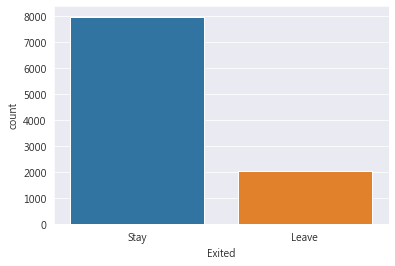

In [4]:
# 觀察目標資料分布
sns.countplot(dataset["Exited"])
plt.xticks((0, 1), ["Stay", "Leave"])

#### 缺失值 Missing Value 檢查

Text(0.5, 1.0, 'Total Missing Value (%) in Dataset')

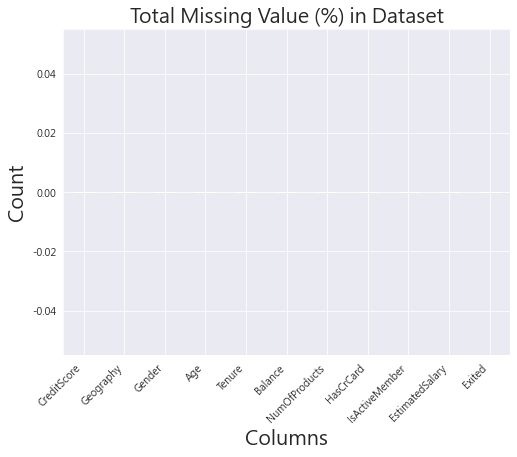

In [5]:
# 檢查缺失值
total = dataset.isnull().sum().sort_values(ascending=False)
percent = (dataset.isnull().sum()/dataset.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# histogram
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%) in Dataset", fontsize = 20)

#### 異常值檢查與處理 outlier
> - 先用 displot 與 boxplot 觀察資料分布
> - 信用分數低, 也是正常的
> - 年齡區間年紀大的都是離群點, 這是正常的
> - 四號商品是離群點, 正常現象
> - 很多人帳號餘額是0元，這是?? 為了信用卡嗎
> - 資料分佈正常,無明顯異常值

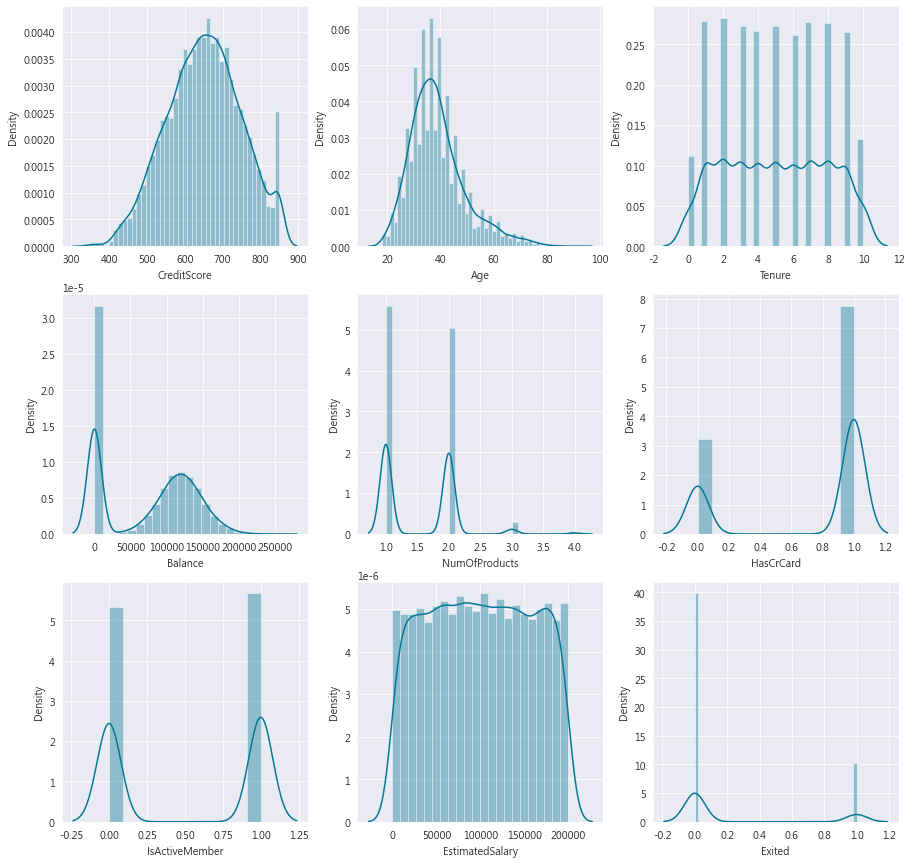

In [6]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

# 觀察所有人的核密度直方圖 查看分布
f, ax = plt.subplots(3, 3, figsize=(15, 15))

i, j  = 0, 0
while i < 3:
    for feature in feature_numerical:
        sns.distplot(dataset[feature], ax = ax[i, j], color = '#047794')
        j = j + 1
        if j > 2:
            i = i + 1
            j = 0

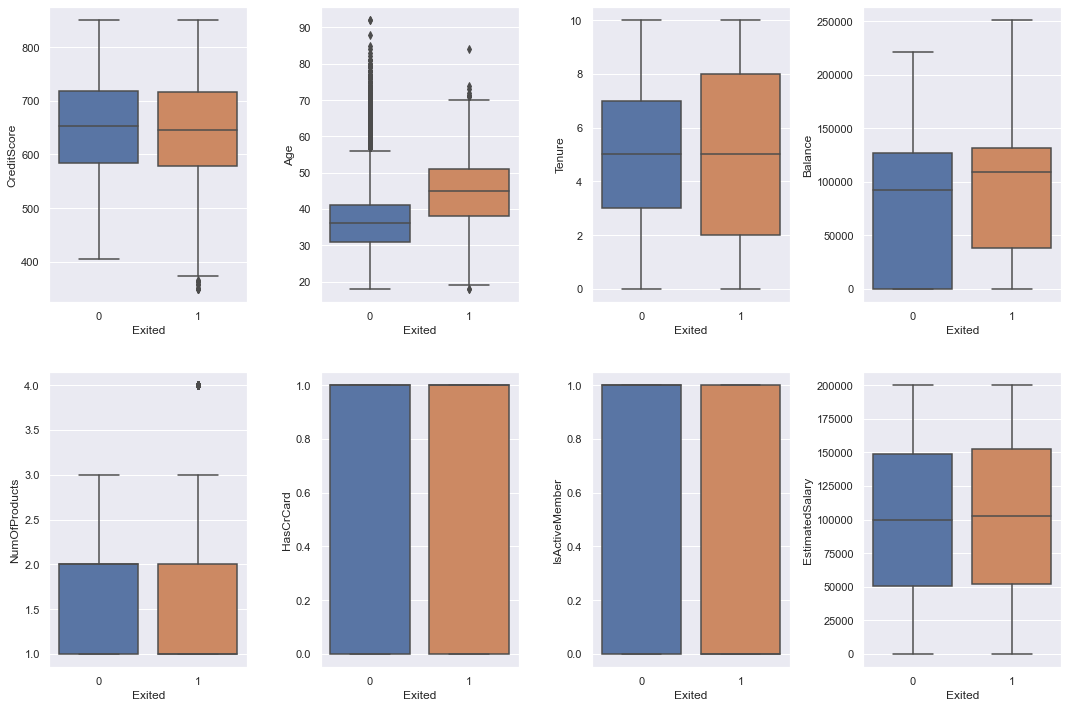

In [24]:
fig, axes = plt.subplots(2,4)
sns.set(rc={'figure.figsize':(15, 10)})
sns.boxplot(x = "Exited", y = "CreditScore", data = dataset,ax = axes[0,0], palette='deep')
sns.boxplot(x = "Exited", y = "Age", data = dataset, ax = axes[0,1], palette='deep')
sns.boxplot(x = "Exited", y = "Tenure", data = dataset, ax = axes[0,2], palette='deep')
sns.boxplot(x = "Exited", y = "Balance", data = dataset, ax = axes[0,3], palette='deep')
sns.boxplot(x = "Exited", y = "NumOfProducts", data = dataset, ax = axes[1,0], palette='deep')
sns.boxplot(x = "Exited", y = "HasCrCard", data = dataset, ax = axes[1,1], palette='deep')
sns.boxplot(x = "Exited", y = "IsActiveMember", data = dataset, ax = axes[1,2], palette='deep')
sns.boxplot(x = "Exited", y = "EstimatedSalary", data = dataset, ax = axes[1,3], palette='deep')
plt.tight_layout(h_pad = 3)

In [8]:
# 觀察資料分布
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.5288,96.65329873613035,350.0,584.0,652.0,718.0,850.0
Age,10000.0,38.9218,10.487806451704609,18.0,32.0,37.0,44.0,92.0
Tenure,10000.0,5.0128,2.8921743770496837,0.0,3.0,5.0,7.0,10.0
Balance,10000.0,76485.889288,62397.405202385955,0.0,0.0,97198.54000000001,127644.24,250898.09
NumOfProducts,10000.0,1.5302,0.5816543579989906,1.0,1.0,1.0,2.0,4.0
HasCrCard,10000.0,0.7055,0.4558404644751333,0.0,0.0,1.0,1.0,1.0
IsActiveMember,10000.0,0.5151,0.49979692845891893,0.0,0.0,1.0,1.0,1.0
EstimatedSalary,10000.0,100090.239881,57510.49281769816,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.2037,0.4027685839948609,0.0,0.0,0.0,0.0,1.0


### EDA 查看各特徵之間的關係

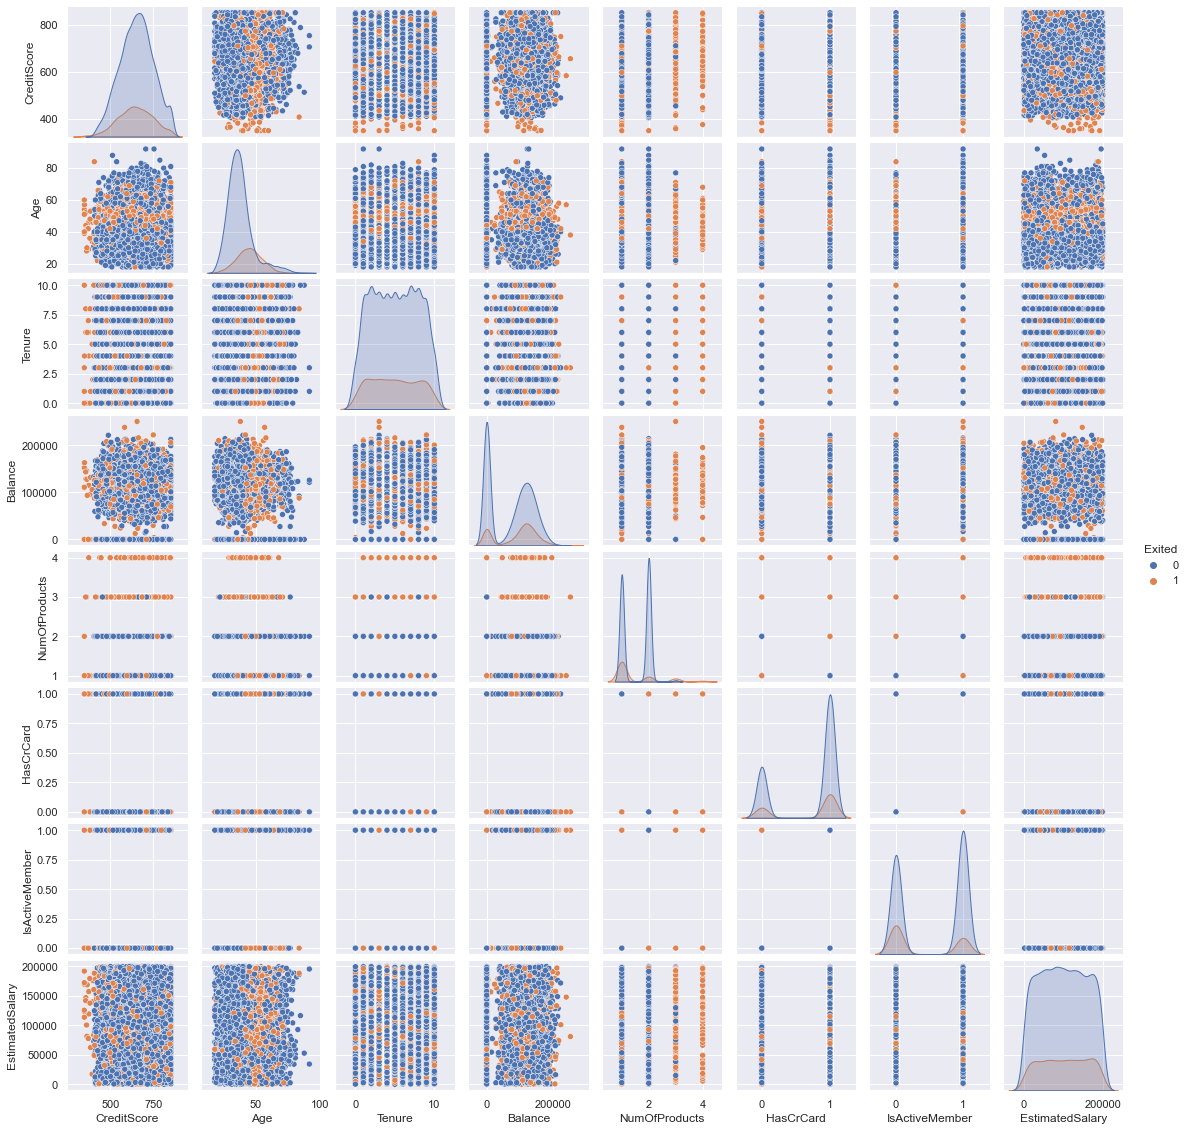

In [9]:
sns.pairplot(dataset, hue="Exited", height=2, diag_kind="kde")

### EDA (Exploratory Data Analysis) 探索式資料分析 (數值特徵)
> - 先用 displot 與 describe 觀察資料分布  
> - 信用分數較高的, 超過600分的 似乎比較容易留下
> - 觀察年紀與忠誠度的關係: 年紀越大越有可能去其他銀行 
> - 客戶一直是該銀行的客戶年數越高，離開的機率就越低
> - 銀行餘額越高似乎，離開的機率比較高
> - 購買的商品，可以看出購買產品２的客戶留下來的機率最大，商品４似乎買的人都走了，看來此商品有問題
> - 有信用卡的客戶離開的比例較低一點點，無明顯差異
> - 活耀的客戶明顯更願意留下
> - 預估的薪資與離開銀行似乎沒有太大的關係

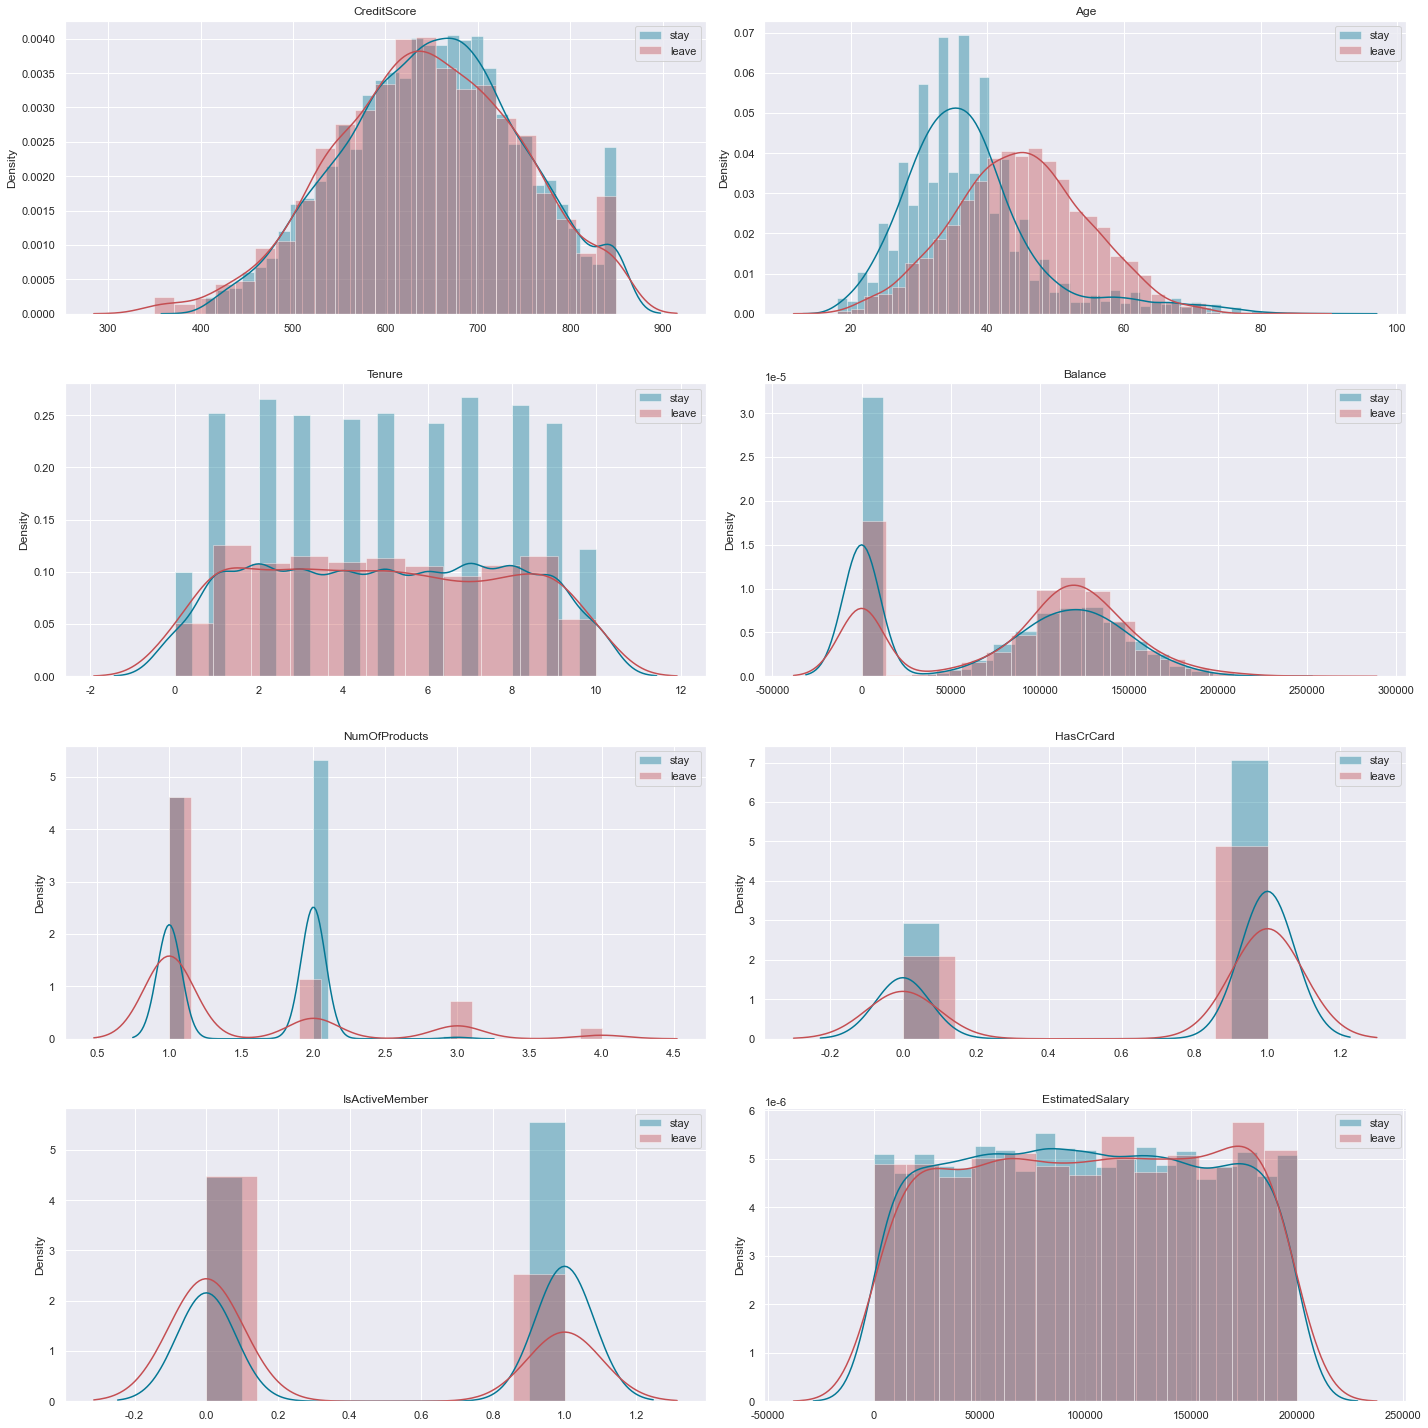

In [21]:
# 觀察數值類型的特徵
plt.figure(figsize=(20,20))
# enumerate 列舉 ==> i :index ; source: 內容
for i, source in enumerate(['CreditScore','Age','Tenure','Balance','NumOfProducts','HasCrCard','IsActiveMember','EstimatedSalary']):
    # 指定好子圖的位置 
    plt.subplot(4, 2, i+1)
    # kdeplot
    sns.distplot(dataset.loc[dataset['Exited']==0, source], color = '#047794', label='stay').set(xlabel=None)
    sns.distplot(dataset.loc[dataset['Exited']==1, source], color = 'r', label='leave').set(xlabel=None)
    plt.legend() 
    plt.title(source)
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

### EDA (Exploratory Data Analysis) 探索式資料分析 (類別特徵)
> - 明顯看出資料集中留下的客戶佔大多數，且大多為法國人
> - 女生離開銀行的比率比男生高一點 (難道是為了刷卡的信用卡優惠?)
> - 德國人離開銀行的比例最高

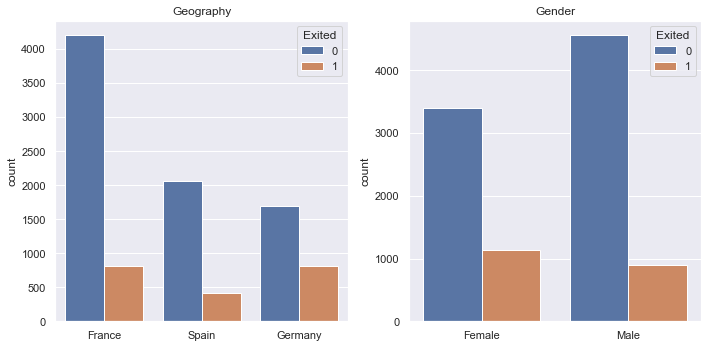

In [11]:
# 觀察 Object 類型的特徵
plt.figure(figsize=(10,5))
for i, source in enumerate(['Geography','Gender',]):
    # 指定好子圖的位置 
    plt.subplot(1, 2, i+1)
    sns.countplot(dataset[source], hue=dataset['Exited'], palette='deep').set(xlabel=None)
    plt.title(source)

    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

### EDA (Exploratory Data Analysis) 探索式資料分析 (特別關注)
> - 針對年紀 : 51~60歲竟然特別會離開銀行
> - 針對信用分數 : 低於399分都全部都離開了, 信用分數有越高客戶越忠誠的趨勢，但不明顯

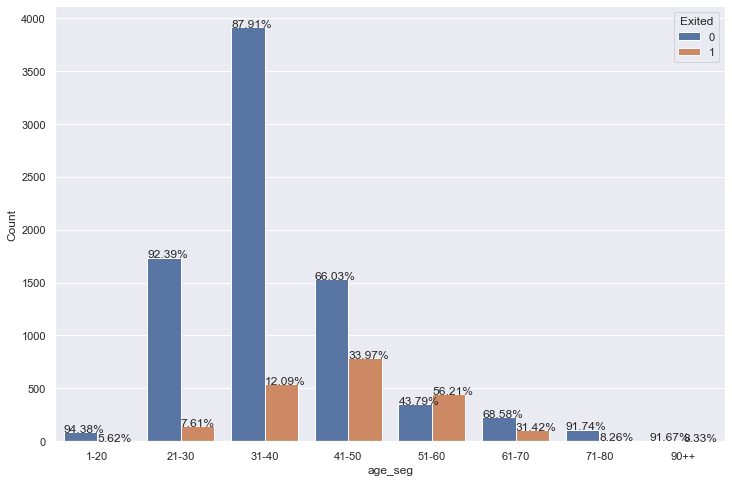

In [12]:
# 針對年紀特徵再做一次分析 : 明顯看出中年人各傾向於離開銀行!????
df_age = dataset.copy()
# 新增年紀區間特徵
df_age['age_seg'] = np.where(dataset['Age'] <= 20, '1-20',
                             np.where(dataset['Age'] <= 30, '21-30',
                             np.where(dataset['Age'] <= 40, '31-40',
                             np.where(dataset['Age'] <= 50, '41-50',
                             np.where(dataset['Age'] <= 60, '51-60',
                             np.where(dataset['Age'] <= 70, '61-70',
                             np.where(dataset['Age'] <= 80, '71-80', 
                             '90++')))))))                  
# 統計相對應的人數
df_age = df_age.groupby(['age_seg', 'Exited']).agg({'Age' : 'count'}).reset_index()
df_age.columns = ['age_seg','Exited','count']

plt.figure(figsize=(12,8))
sns.barplot(data = df_age, x = 'age_seg', y = 'count', hue = 'Exited', palette = 'deep')
plt.ylabel('Count')

# 建立百分比標籤
df_age['total_user'] = df_age.groupby(['age_seg'])['count'].transform('sum')
df_age['Percentage'] = round(df_age['count']/df_age['total_user']*100,2).astype(str)+'%'

x_position = -0.4
for i in range(df_age['Percentage'].count()):
    plt.text(x = x_position , y = df_age['count'][i], s = df_age['Percentage'][i], fontsize = 12)
    if i % 2 != 0:
        x_position = x_position + 0.6
    else:
        x_position = x_position + 0.4


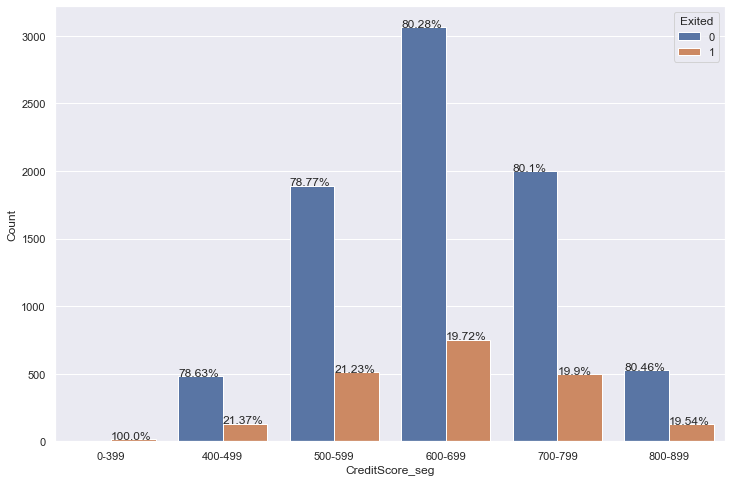

In [13]:
# 針對信用分數特徵再做一次分析 : 
df_CreditScore = dataset.copy()
# 新增信用分數區間特徵
df_CreditScore['CreditScore_seg'] = np.where(dataset['CreditScore'] <= 399, '0-399',
                                    np.where(dataset['CreditScore'] <= 499, '400-499',
                                    np.where(dataset['CreditScore'] <= 599, '500-599',
                                    np.where(dataset['CreditScore'] <= 699, '600-699',
                                    np.where(dataset['CreditScore'] <= 799, '700-799',
                                    np.where(dataset['CreditScore'] <= 899, '800-899',
                                     '900++'))))))              
# 統計相對應的人數
df_CreditScore = df_CreditScore.groupby(['CreditScore_seg', 'Exited']).agg({'CreditScore' : 'count'}).reset_index()
df_CreditScore.columns = ['CreditScore_seg','Exited','count']

plt.figure(figsize=(12,8))
sns.barplot(data = df_CreditScore, x = 'CreditScore_seg', y = 'count', hue = 'Exited', palette = 'deep')
plt.ylabel('Count')

# 建立百分比標籤
df_CreditScore['total_user'] = df_CreditScore.groupby(['CreditScore_seg'])['count'].transform('sum')
df_CreditScore['Percentage'] = round(df_CreditScore['count']/df_CreditScore['total_user']*100,2).astype(str)+'%'

x_position = 0
for i in range(df_CreditScore['Percentage'].count()):
    plt.text(x = x_position , y = df_CreditScore['count'][i], s = df_CreditScore['Percentage'][i], fontsize = 12)
    if i % 2 != 0:
        x_position = x_position + 0.4
    else:
        x_position = x_position + 0.6


## 特徵工程
>1. 特徵建構: 從原始數據中人工的構建新的特徵，取代原始數據的特徵  
>2. 特徵提取: 將機器學習演算法不能識別的原始數據，轉化為演算法可以識別的特徵
    - 特徵提取的首要任務是將變數從文字轉換成數字，連續數值轉為離散數值，以利統計與導入演算法模型
>3. 特徵選擇: 從所有的特徵中選擇一組最好的特徵集，捨去無關的特徵，保留相關性高的特徵
    - 使用相關性作圖(Pearson相關係數)，顏色較淺的部分為沒有關係的，顏色偏藍就是正相關，顏色偏紅就是負相關。

### 1. 特徵建構

### 2. 特徵提取

In [14]:
# one-hot-Encoding 類別資料 (國家)
dataset = pd.get_dummies(data = dataset, columns=['Geography'])

# Label-Encoding 類別資料 (性別)
dataset['Gender'] = LabelEncoder().fit_transform(dataset['Gender'])

dataset.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.0,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.8,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.0,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.1,0,0,0,1


### 3. 特徵選擇

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

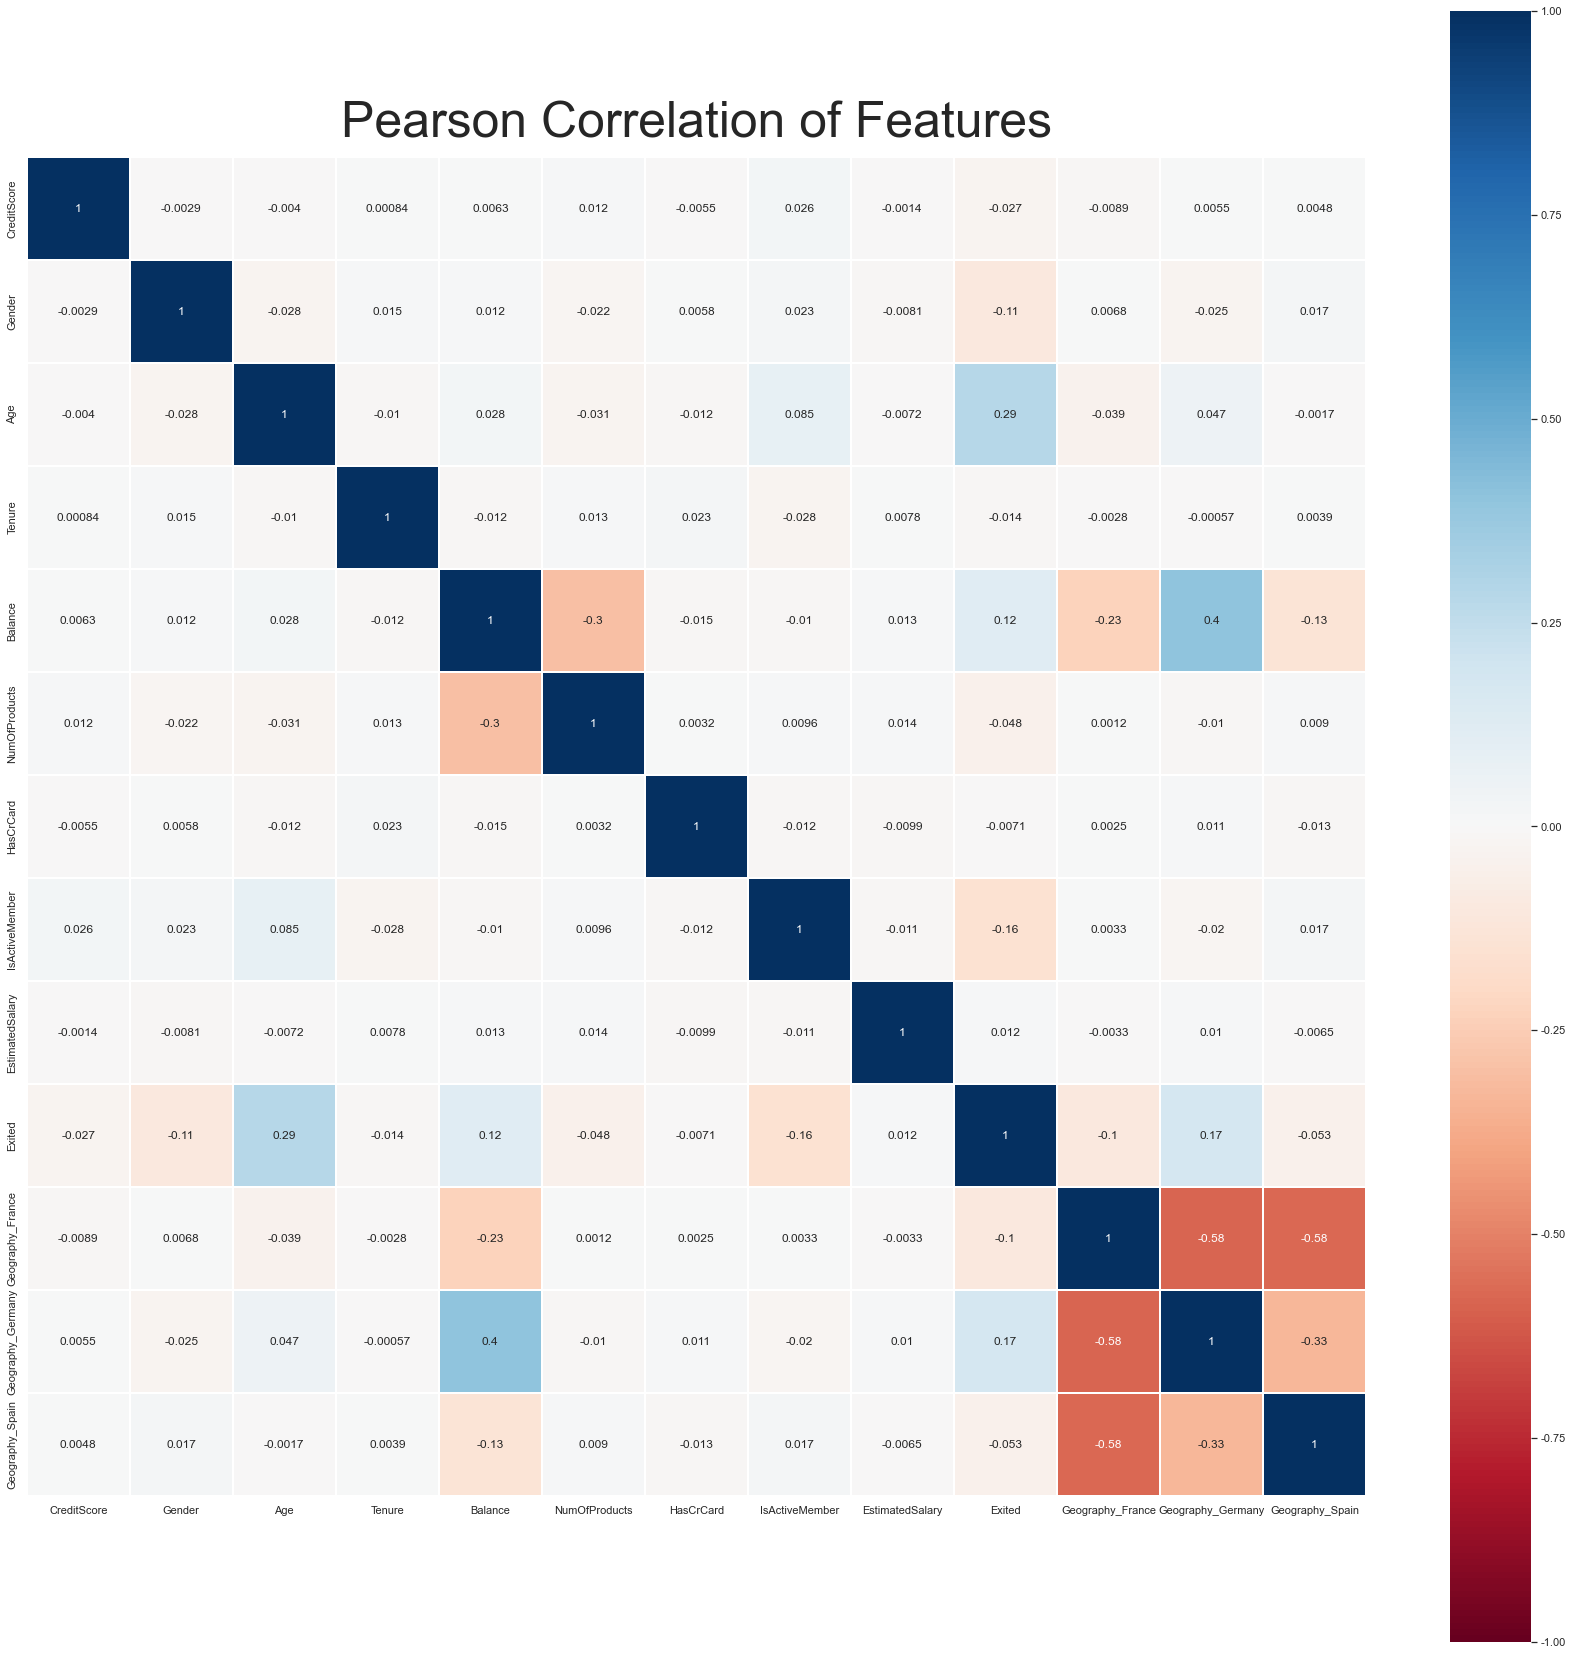

In [15]:
# 先建立空圖
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 30))
plt.title('Pearson Correlation of Features', y = 1.01, size = 50)

# 再將資料加入圖中
sns.heatmap(dataset.astype(float).corr(), linewidths = 0.1, vmin = -1.0 ,vmax = 1.0, square = True, cmap = colormap, 
            linecolor = 'white', annot = True, xticklabels = True, yticklabels = True)

## 準備訓練資料

In [16]:
# 訓練資料處理
y = dataset['Exited']
X = dataset.drop(['Exited'], axis = 1) # 刪除指定column

print('X shape: '+str(X.shape))
print('y shape: '+str(y.shape))

X shape: (10000, 12)
y shape: (10000,)


In [17]:
# 將資料分割成訓練集與測試集
# stratify 分層隨機抽樣，在原始數據中樣本標籤分佈不均衡時非常有用。使用時機是確保分類問題 y 的類別數量分佈要與原資料集一致。以免資料集切割不平均導致模型訓練時有很大的偏差。
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

# 特徵縮放 StandardScaler, MinMaxScaler, RobustScaler 
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train_StandardScaler = pd.DataFrame(X_train)
X_train_StandardScaler.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.8059999999999999,1.0,0.527027027027027,0.7000000000000001,0.0,0.0,1.0,0.0,0.7973936510936793,1.0,0.0,0.0
1,0.7779999999999999,1.0,0.1891891891891892,0.30000000000000004,0.4284127493901108,0.0,1.0,0.0,0.319879498492106,0.0,1.0,0.0
2,0.8099999999999999,0.0,0.25675675675675674,0.0,0.47764753328571335,0.3333333333333333,1.0,1.0,0.5869794065333239,0.0,1.0,0.0
3,0.42200000000000004,1.0,0.25675675675675674,0.5,0.0,0.3333333333333333,1.0,0.0,0.41544802528641483,1.0,0.0,0.0
4,0.684,1.0,0.4189189189189189,0.6000000000000001,0.4637004967876679,0.3333333333333333,0.0,1.0,0.5373583677241176,0.0,1.0,0.0


## 建立模型

### Logistic Regression 邏輯斯迴歸

In [18]:
model_LogisticRegression = LogisticRegression()

# 先對模型做交叉驗證，並找出最佳參數
parameters = dict(
                    C=range(1, 10),
                    max_iter=range(1, 1000)
                 )

model_LogisticRegression_rs = RandomizedSearchCV(model_LogisticRegression, parameters, random_state=0, n_iter=10, cv=10).fit(X_train, y_train)

model_LogisticRegression_rs.best_params_

model_LogisticRegression = LogisticRegression(random_state=42, C = model_LogisticRegression_rs.best_params_['C'], max_iter = model_LogisticRegression_rs.best_params_['max_iter'])
model_LogisticRegression.fit(X_train,y_train)

print('Logistic Regression Training score:', model_LogisticRegression.score(X_train, y_train)*100)

#測試測試集
y_test_predict_logreg = model_LogisticRegression.predict(X_test)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_test, y_test_predict_logreg)
print('-------------------------------混淆矩陣-------------------------------')
print(cm) 
print('---------------------------------------------------------------------')
print("準確率（Accuracy）: ", (cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]) )
print("精確率（Precision）: ", (cm[0][0])/(cm[0][0] + cm[0][1]) )
print("召回率（Recall）: ", (cm[0][0])/(cm[0][0] + cm[1][1]) )
print("AUC : ", roc_auc_score(y_test, y_test_predict_logreg).round(2) )

Logistic Regression Training score: 81.16250000000001
-------------------------------混淆矩陣-------------------------------
[[1545   48]
 [ 334   73]]
---------------------------------------------------------------------
準確率（Accuracy）:  0.809
精確率（Precision）:  0.9698681732580038
召回率（Recall）:  0.9548825710754018
AUC :  0.57


### Random Forest 隨機森林

In [19]:
model_rf = RandomForestClassifier()

# 先對模型做交叉驗證，並找出最佳參數
parameters = dict(
                    n_estimators=range(1, 100),
                    max_depth=range(1, 100)
                 )

model_rf_rs = RandomizedSearchCV(model_rf, parameters, random_state=0, n_iter=10).fit(X_train, y_train)
model_rf_rs.best_params_

model_rf = RandomForestClassifier(
    n_estimators = model_rf_rs.best_params_['n_estimators'],
    max_depth = model_rf_rs.best_params_['max_depth']
)

model_rf.fit(X_train, y_train)

print('Random Forest Training score:', model_rf.score(X_train, y_train)*100)

y_test_predict_rf = model_rf.predict(X_test)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_test, y_test_predict_rf)
print('-------------------------------混淆矩陣-------------------------------')
print(cm) 
print('---------------------------------------------------------------------')
print("準確率（Accuracy）: ", (cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]) )
print("精確率（Precision）: ", (cm[0][0])/(cm[0][0] + cm[0][1]) )
print("召回率（Recall）: ", (cm[0][0])/(cm[0][0] + cm[1][1]) )
print("AUC : ", roc_auc_score(y_test, y_test_predict_rf).round(2) )

Random Forest Training score: 100.0
-------------------------------混淆矩陣-------------------------------
[[1536   57]
 [ 215  192]]
---------------------------------------------------------------------
準確率（Accuracy）:  0.864
精確率（Precision）:  0.9642184557438794
召回率（Recall）:  0.8888888888888888
AUC :  0.72


### LightGBM 

In [20]:
model_lgb = lgb.LGBMClassifier()

parameters = {
        'n_estimators':range(20, 200, 4),
        'max_depth':range(1, 50, 1),
        'learning_rate':np.linspace(0.01, 2, 20),
        'subsample':np.linspace(0.7, 0.9, 20),
        'colsample_bytree':np.linspace(0.5, 0.98, 10),
        'min_child_weight':range(1, 9, 1)
        }

model_lgb_rs = RandomizedSearchCV(model_lgb, parameters, random_state=0, n_iter=10, cv=10).fit(X_train, y_train)
model_lgb_rs.best_params_

model_lgb = lgb.LGBMClassifier(
    n_estimators = model_lgb_rs.best_params_['n_estimators'],
    max_depth = model_lgb_rs.best_params_['max_depth'],
    learning_rate = model_lgb_rs.best_params_['learning_rate'],
    subsample = model_lgb_rs.best_params_['subsample'],
    colsample_bytree = model_lgb_rs.best_params_['colsample_bytree'],    
    min_child_weight = model_lgb_rs.best_params_['min_child_weight'],                               
  )

model_lgb.fit(X_train, y_train)

print('LightGBM Training score:', model_lgb.score(X_train, y_train)*100)

y_test_predict_lgb = model_lgb.predict(X_test)
# 建立混淆矩陣，計算 Accuracy、Precision、Recell、F值等衡量指標
cm = confusion_matrix(y_test, y_test_predict_lgb)
print('-------------------------------混淆矩陣-------------------------------')
print(cm) 
print('---------------------------------------------------------------------')
print("準確率（Accuracy）: ", (cm[0][0] + cm[1][1])/(cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]) )
print("精確率（Precision）: ", (cm[0][0])/(cm[0][0] + cm[0][1]) )
print("召回率（Recall）: ", (cm[0][0])/(cm[0][0] + cm[1][1]) )
print("AUC : ", roc_auc_score(y_test, y_test_predict_lgb).round(2) )

LightGBM Training score: 87.25
-------------------------------混淆矩陣-------------------------------
[[1542   51]
 [ 220  187]]
---------------------------------------------------------------------
準確率（Accuracy）:  0.8645
精確率（Precision）:  0.967984934086629
召回率（Recall）:  0.891844997108155
AUC :  0.71
